In [6]:
from obspy.core import Stream, read, UTCDateTime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
from matplotlib.colors import Normalize
import pandas as pd
import os 
import os.path

In [7]:
path = '/Users/sydneydybing/StrainProject/2024/taiwan_strain_data/'

snr_array = pd.read_csv(path + 'station_data_hypdists_snrs.csv')
events = pd.read_csv(path + 'events_csv.csv')

In [8]:
events

,evt_id,origin_time,lat,lon,depth
0,2009-10-03_M6.1,2009-10-03T17:36:06.120,23.630,121.452,28.0
1,2013-10-31_M6.3,2013-10-31T12:02:08.720,23.590,121.437,10.0
2,2018-02-04_M6.1,2018-02-04T13:56:41.950,24.157,121.708,12.0


In [9]:
snr_array

,Sta,Lat,Lon,Depth(m),2009_hyp_dist_km,2013_hyp_dist_km,2018_hyp_dist_km,snrs_2009,snrs_2013,snrs_2018
0,BCWB,24.2184,121.6891,-192,69.496535,74.182696,7.066640,-,-,-
1,TRKB,24.1614,121.6127,-192,61.088805,65.767547,9.697232,-,1152.20250487,3719.0718215
2,NTTB,24.1728,121.5259,-175,60.587926,65.180780,18.587874,-,-,-
3,SJNB,24.1073,121.6006,-193,54.988063,59.668808,12.226300,-,1534.07924347,130.500478359
4,HGSB,23.4903,121.4237,-266,15.739505,11.125139,79.319331,-,439.289654937,372.018353576
5,CHMB,23.4868,121.4703,-191,15.969342,11.924641,78.079695,-,348.253341927,40.3376474275
6,SSNB,23.4423,121.3981,-185,21.504342,16.833483,85.224271,-,766.890947625,129.005945014
7,ZANB,23.3947,121.4585,-218,26.068219,21.740867,88.175343,-,3295.27964074,106.461336916
8,FBRB,23.1406,121.2796,-200,56.994188,52.307853,120.756809,-,410.300738921,80.3548941939
9,SSTB,23.1340,121.3782,-199,55.447392,50.858196,118.191393,-,359.179515365,47.0870229521


2009-10-03_M6.1
BCWB
TRKB
NTTB
SJNB
HGSB
CHMB
SSNB
ZANB
FBRB
SSTB
DONB
2013-10-31_M6.3
BCWB
TRKB


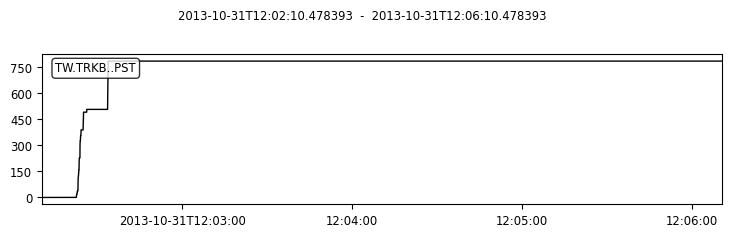

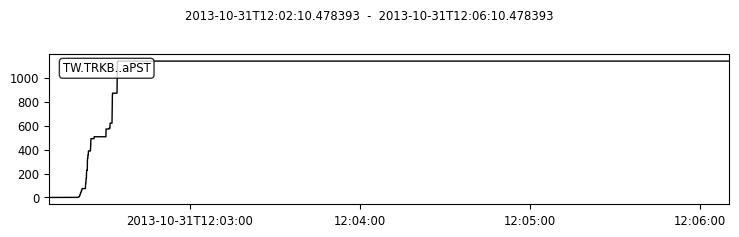

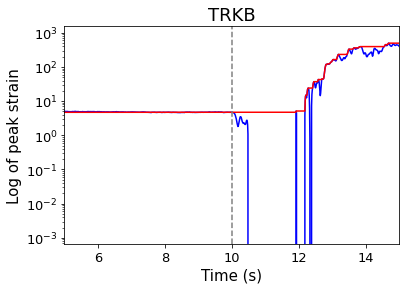

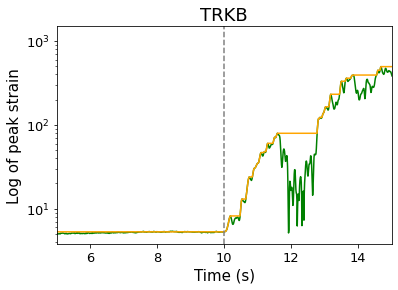

NTTB
SJNB


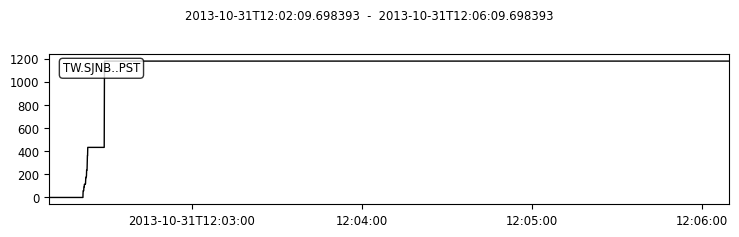

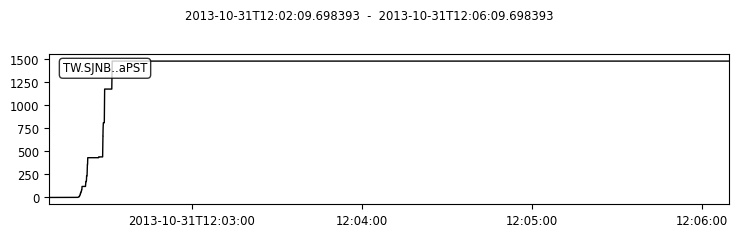

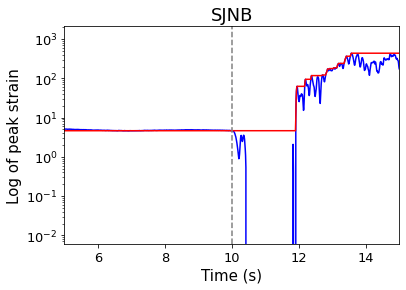

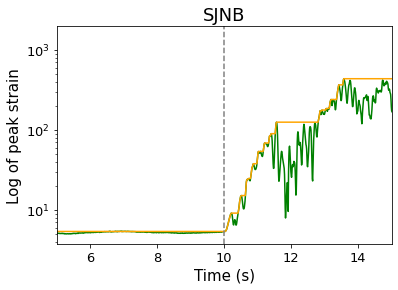

HGSB


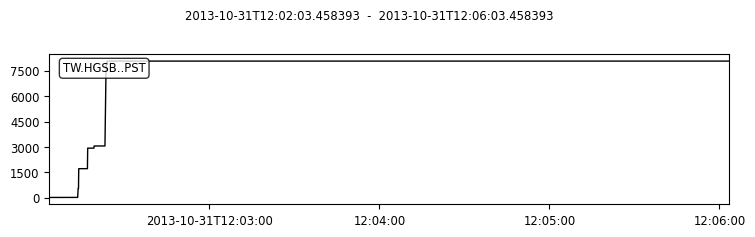

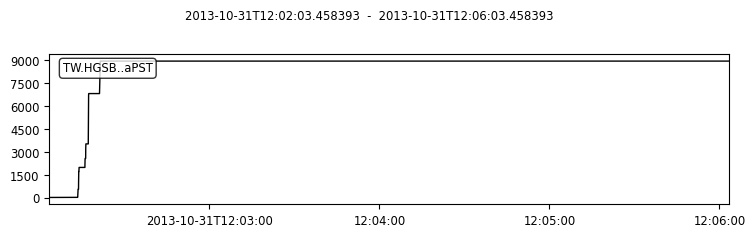

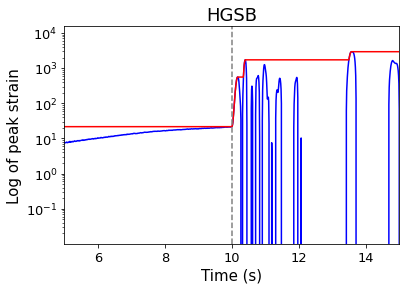

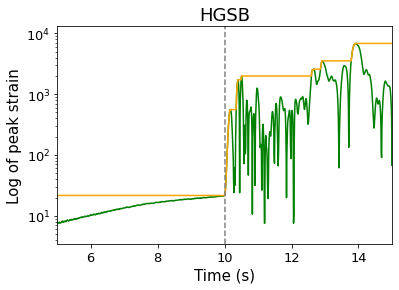

CHMB


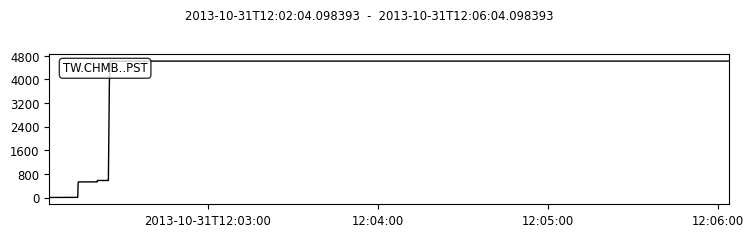

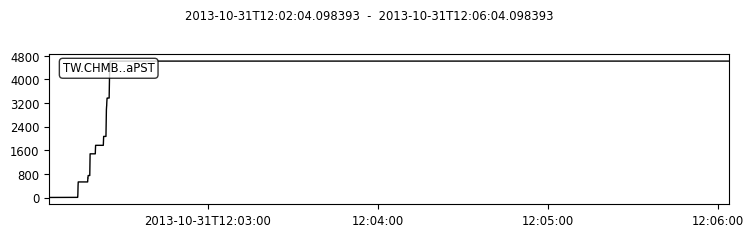

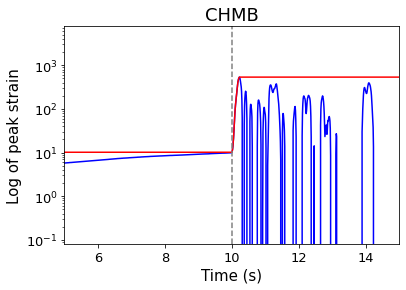

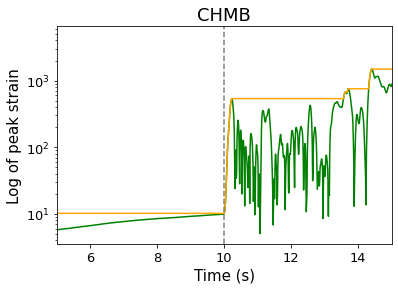

SSNB


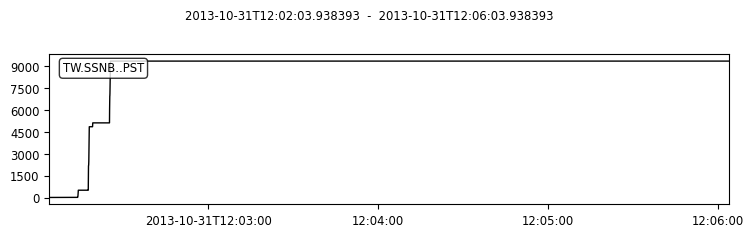

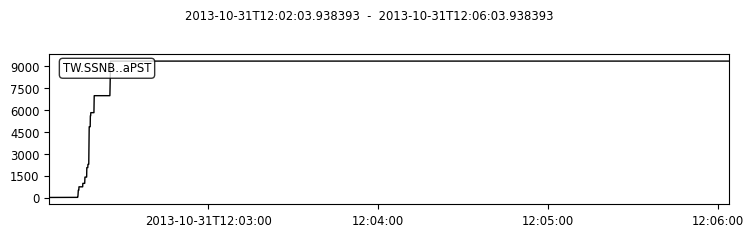

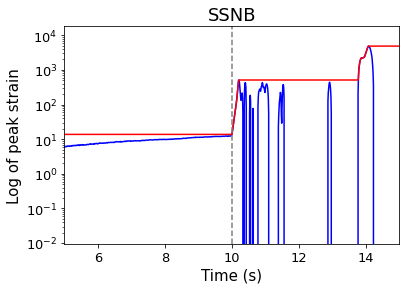

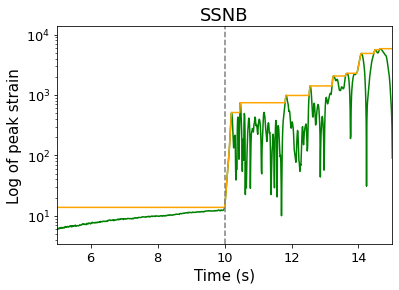

ZANB


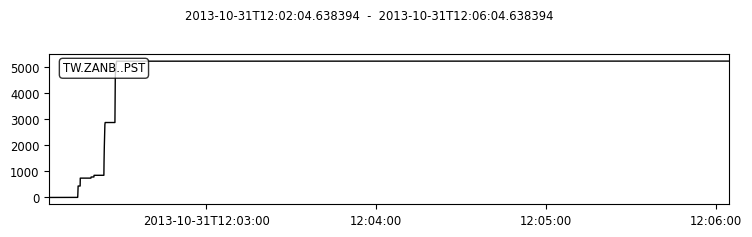

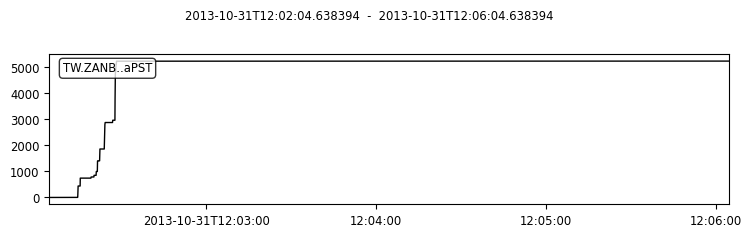

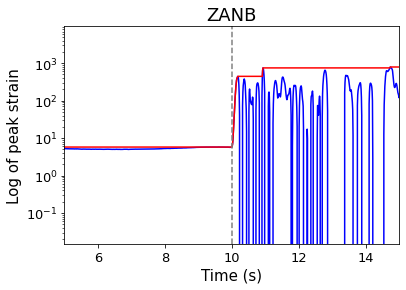

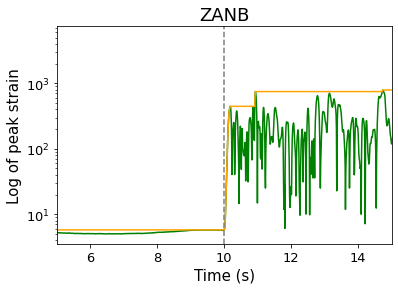

FBRB


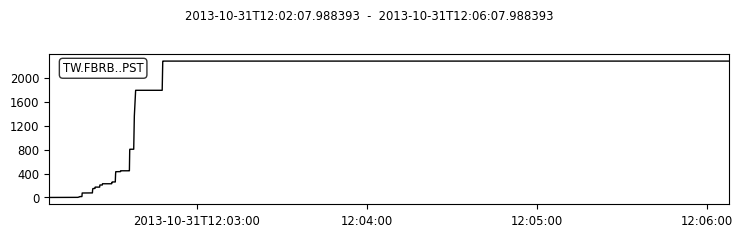

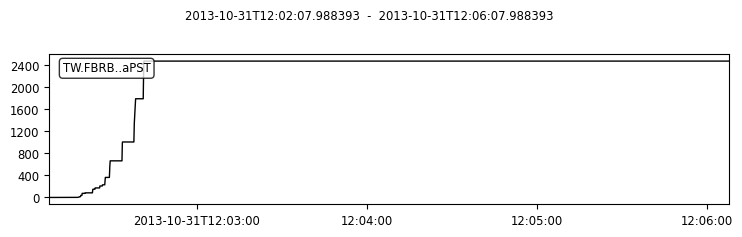

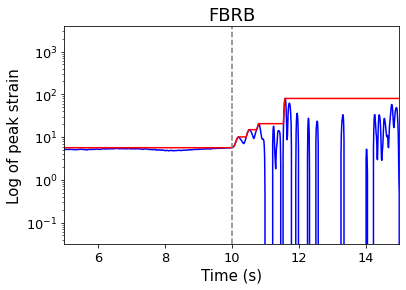

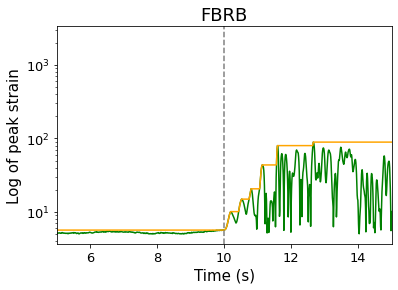

SSTB


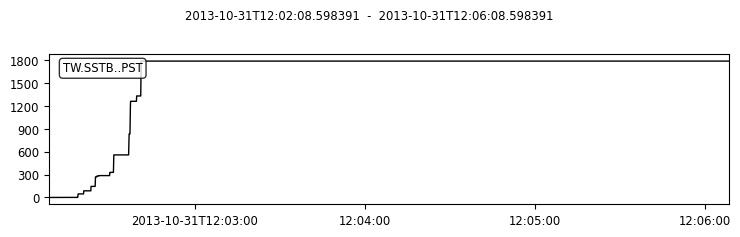

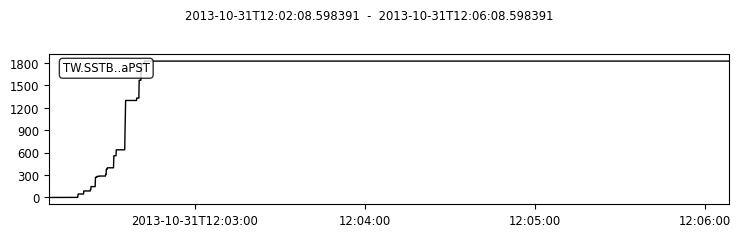

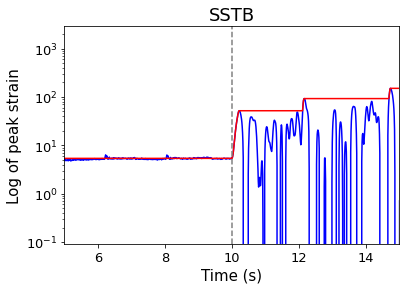

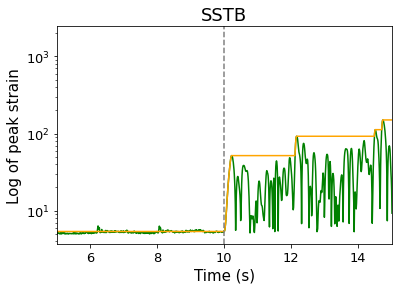

DONB


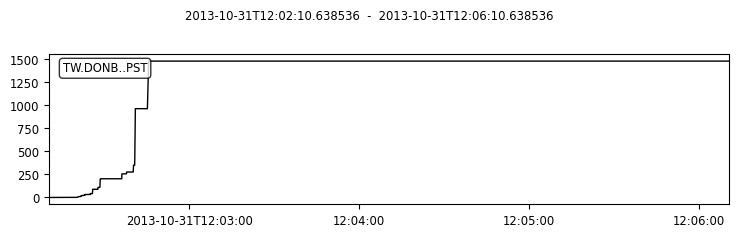

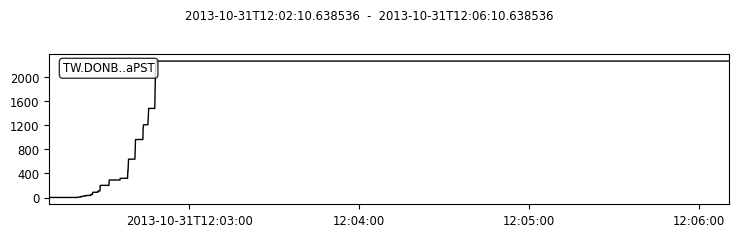

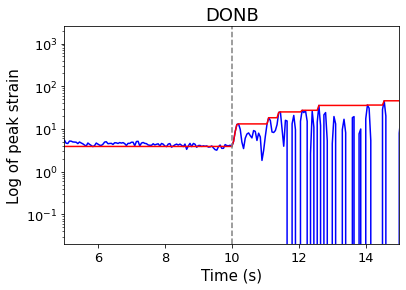

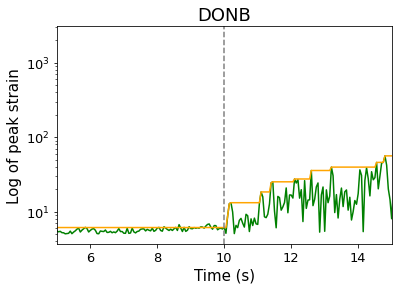

2018-02-04_M6.1
BCWB
TRKB


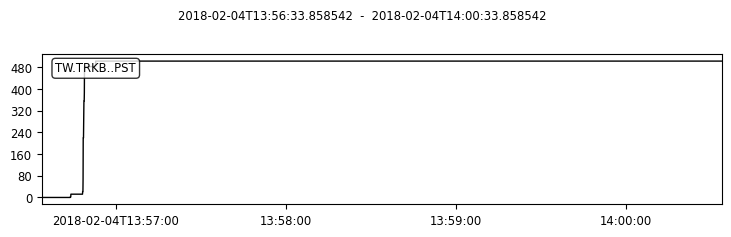

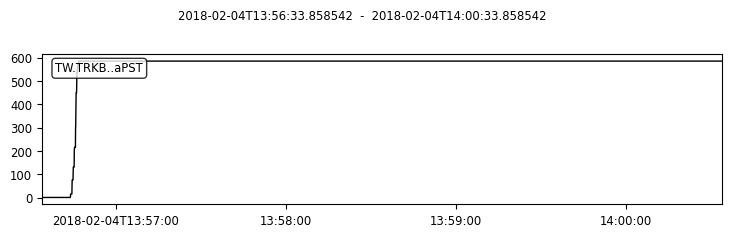

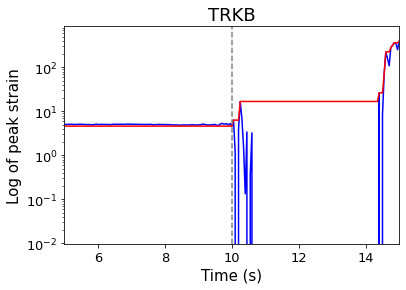

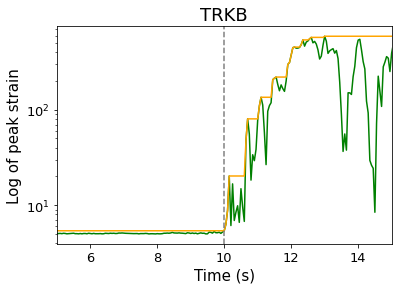

NTTB
SJNB


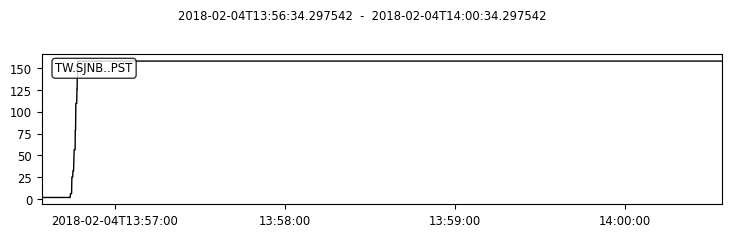

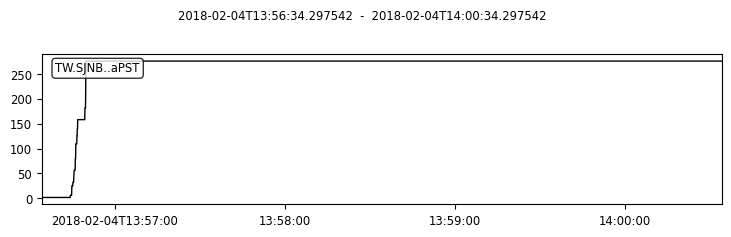

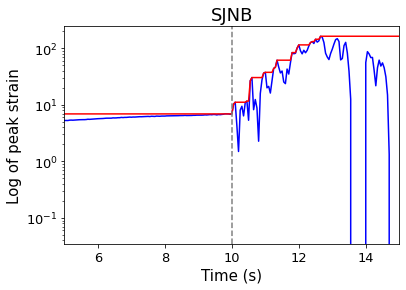

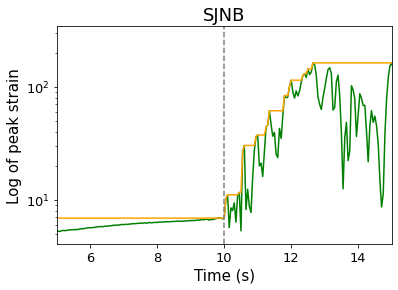

HGSB


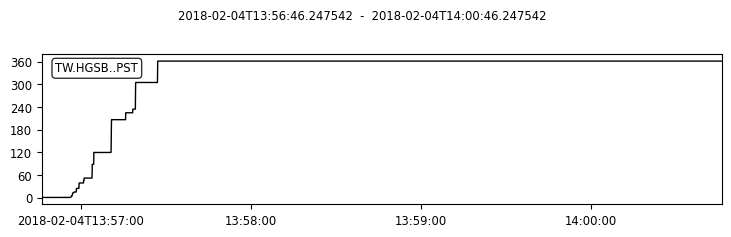

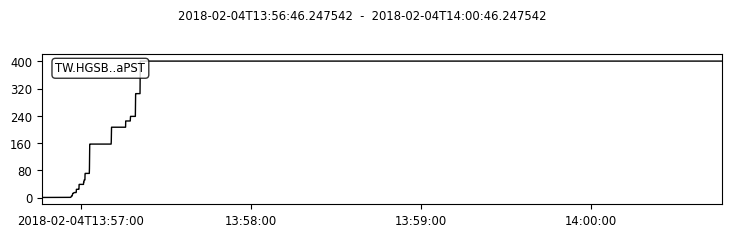

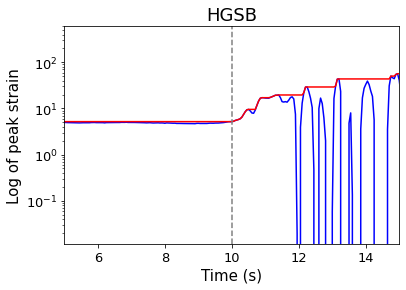

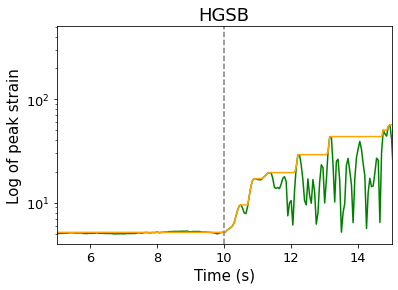

CHMB


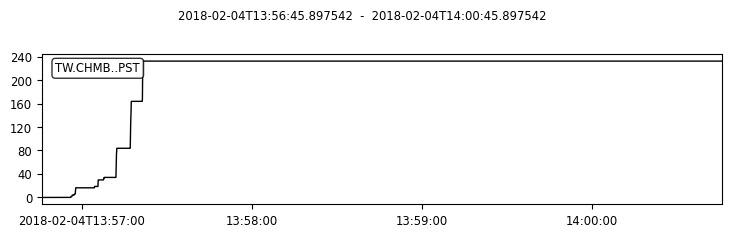

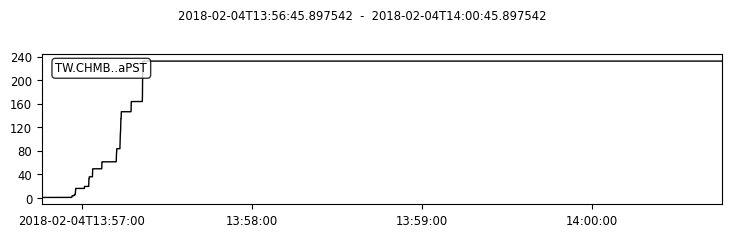

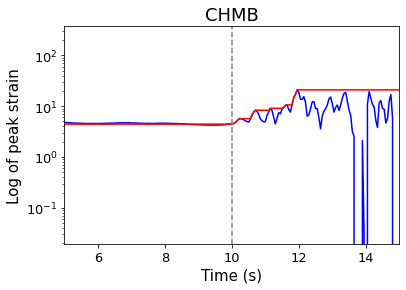

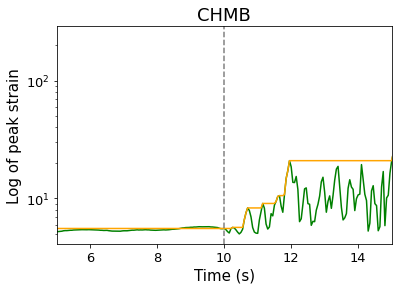

SSNB


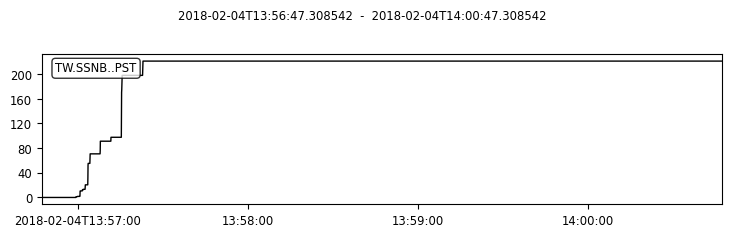

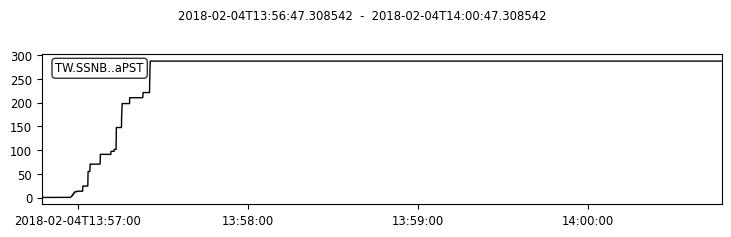

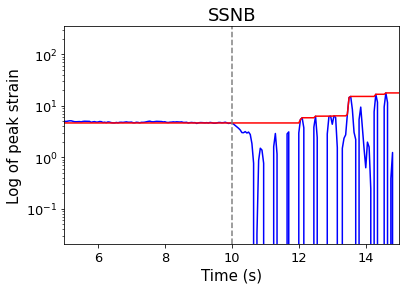

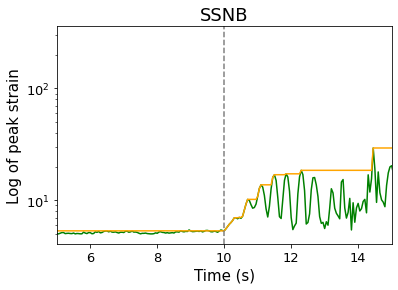

ZANB


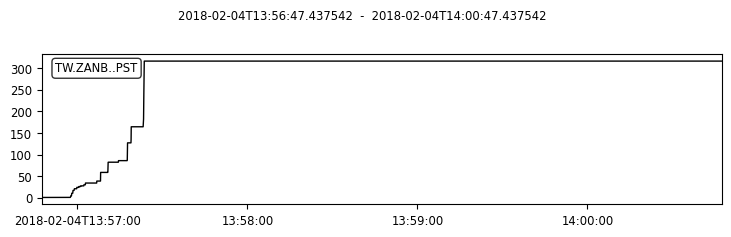

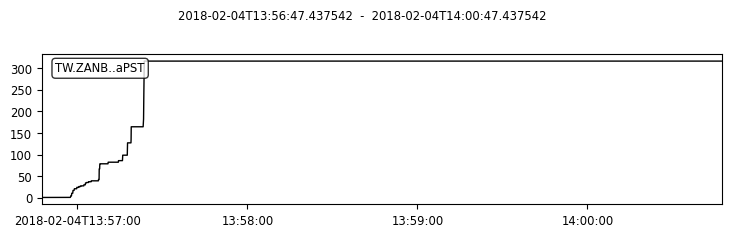

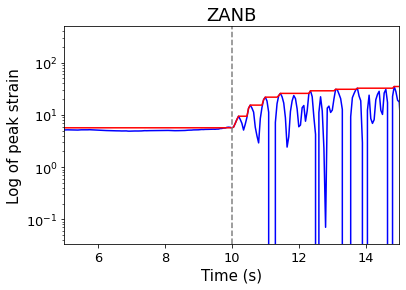

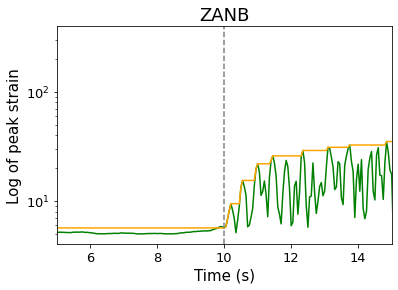

FBRB


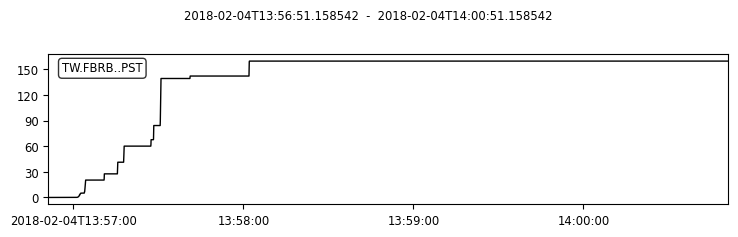

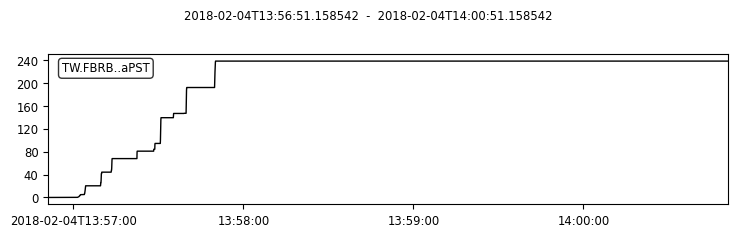

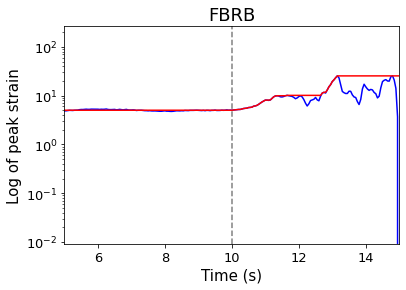

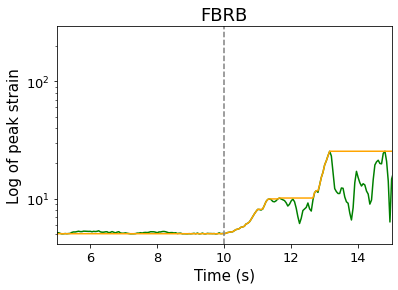

SSTB


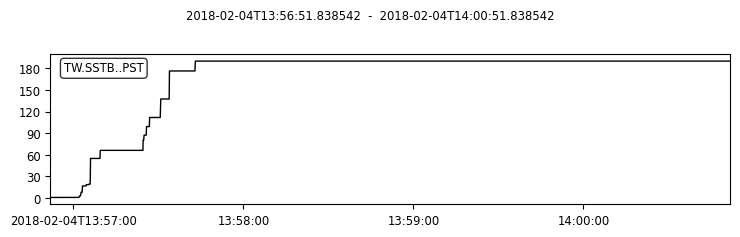

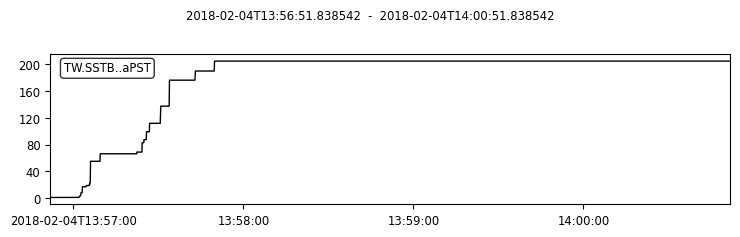

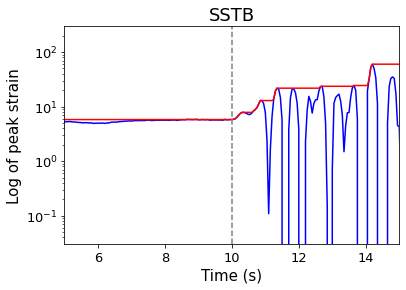

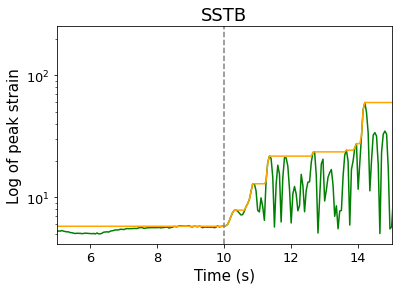

DONB


In [10]:
for i in range(len(events)):
    
    evt_id = events['evt_id'][i]
    print(evt_id)
    origin_time = UTCDateTime(events['origin_time'][i])
    # print(origin_time)

    for idx in range(len(snr_array)):

        sta = snr_array['Sta'][idx]
        print(sta)
        # plt.figure(figsize = (10,6), dpi = 300, facecolor = 'white', num = 1, clear = True)

        # Strain data
        try:
            ev = read(path + 'filtered_trimmed_EV/' + evt_id + '/' + sta + '.mseed')
            aev = read(path + 'filtered_trimmed_abs_EV/' + evt_id + '/' + sta + '.mseed')
        except:
            continue
    
        # Non-abs strain
        
        mod_strain = ev.copy()
        strain_times = ev[0].times()
        strain_data = ev[0].data
        mod_strain_times = mod_strain[0].times()
        mod_strain_data = mod_strain[0].data
        samp_rate = ev[0].stats.sampling_rate

        # Set the strain before the P-wave to the strain at the P-wave arrival
        p_arrival_strain = strain_data[int(10*samp_rate)]
        mod_strain_data[:int(10*samp_rate)] = p_arrival_strain

        # Calculate peak strain again on new modified RMS strain

        pst = mod_strain.copy()

        # Loop over samples
        for k in range(0,len(mod_strain[0].data)): #avoid starting at zero

            if k == 0:
                strain = mod_strain_data[0]
                max_strain = strain

            else:
                # Grab progressively longer windows and save the biggest strain
                strain = mod_strain_data[:k+1] # Has to be k+1 because slicing doesn't include last one
                max_strain = max(strain)

            # Put peak strain back into the output stream
            pst[0].data[k] = max_strain 

        pst_times = pst[0].times()
        pst_data = pst[0].data
        pst[0].stats.channel = 'PST' 
        
        # Abs strain
        
        amod_strain = aev.copy()
        astrain_times = aev[0].times()
        astrain_data = aev[0].data
        amod_strain_times = amod_strain[0].times()
        amod_strain_data = amod_strain[0].data
        asamp_rate = aev[0].stats.sampling_rate

        # Set the strain before the P-wave to the strain at the P-wave arrival
        ap_arrival_strain = astrain_data[int(10*asamp_rate)]
        amod_strain_data[:int(10*asamp_rate)] = ap_arrival_strain

        # Calculate peak strain again on new modified RMS strain

        apst = amod_strain.copy()

        # Loop over samples
        for k in range(0,len(amod_strain[0].data)): #avoid starting at zero

            if k == 0:
                astrain = amod_strain_data[0]
                amax_strain = astrain

            else:
                # Grab progressively longer windows and save the biggest strain
                astrain = amod_strain_data[:k+1] # Has to be k+1 because slicing doesn't include last one
                amax_strain = max(astrain)

            # Put peak strain back into the output stream
            apst[0].data[k] = amax_strain 

        apst_times = apst[0].times()
        apst_data = apst[0].data
        apst[0].stats.channel = 'aPST' 
        
        pst.plot()
        apst.plot()
        
        plt.title(sta, fontsize = 18)
        plt.plot(ev[0].times(), ev[0].data+5, color = 'blue')
        plt.plot(pst[0].times(), pst[0].data+5, color = 'red')
        plt.semilogy()
        plt.ylabel('Log of peak strain', fontsize = 15)
        plt.xlabel('Time (s)', fontsize = 15)
        plt.xlim(5,15)
        # plt.ylim(min(pst_data[int(5*20):int(60*20)]), max(pst_data[int(5*20):int(60*20)])*1.1)
        plt.axvline(10, color = 'gray', linestyle = '--')
        plt.tick_params(labelsize = 13)
        plt.show()
        
        plt.title(sta, fontsize = 18)
        plt.plot(aev[0].times(), aev[0].data+5, color = 'green')
        plt.plot(apst[0].times(), apst[0].data+5, color = 'orange')
        plt.semilogy()
        plt.ylabel('Log of peak strain', fontsize = 15)
        plt.xlabel('Time (s)', fontsize = 15)
        plt.xlim(5,15)
        # plt.ylim(min(pst_data[int(5*20):int(60*20)]), max(pst_data[int(5*20):int(60*20)])*1.1)
        plt.axvline(10, color = 'gray', linestyle = '--')
        plt.tick_params(labelsize = 13)
        plt.show()

        # Create folder for the event
        eq_sta_save_dir = path + 'filtered_peak_post_p/' + evt_id + '/'
        # print(eq_sta_save_dir)
        if os.path.isdir(eq_sta_save_dir):
            pass
        else:
            os.makedirs(eq_sta_save_dir)

        pst.write(eq_sta_save_dir + sta + '.mseed', format = 'MSEED')
        
        # Create folder for the event
        eq_sta_save_dir = path + 'filtered_abs_peak_post_p/' + evt_id + '/'
        # print(eq_sta_save_dir)
        if os.path.isdir(eq_sta_save_dir):
            pass
        else:
            os.makedirs(eq_sta_save_dir)

        apst.write(eq_sta_save_dir + sta + '.mseed', format = 'MSEED')
